In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
# Danh sách lớp (giờ chỉ cần 1 lớp chung)
class_names = ['food']  # Chỉ có 1 lớp chung cho bounding box
class_to_idx = {name: 0 for name in class_names}  # Chỉ có idx = 0

class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        
        all_images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.images = []
        for img_name in all_images:
            label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt'))
            if not os.path.exists(label_path):
                continue
            with open(label_path, 'r') as f:
                lines = f.readlines()
            num_boxes = len(lines)
            if num_boxes == 2: 
                self.images.append(img_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Đọc ảnh
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Đọc nhãn bounding box (không cần class_id từ tên file nữa)
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt'))
        with open(label_path, 'r') as f:
            lines = f.readlines()
        box = [list(map(float, line.split()))[1:] for line in lines]  # Lấy [x, y, w, h] cho cả 2 box
        labels = torch.tensor(box)  # [2, 4] (2 box, mỗi box có x, y, w, h)
        
        # Áp dụng transform cho ảnh
        if self.transform:
            image = self.transform(image)
        
        return image, labels

# Khởi tạo dataset
transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
dataset = CustomDataset('./Data/object-detection/train/images', 
                       './Data/object-detection/train/labels', transform=transform)


In [8]:
# Chia dataset
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Hàm collate_fn để xử lý batch (không cần phức tạp vì giờ chỉ có 1 box)
def collate_fn(batch):
    images, labels = zip(*batch)
    return torch.stack(images), torch.stack(labels)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

print(f'Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}')

Train size: 2044, Validation size: 255, Test size: 256


In [9]:
# Hàm tính IoU giữa hai tập hợp bounding box
def calculate_iou(pred_boxes, target_boxes):
    pred_boxes = pred_boxes.view(-1, 2, 4)
    target_boxes = target_boxes.view(-1, 2, 4)
    batch_size = pred_boxes.size(0)
    iou_scores = torch.zeros(batch_size, 2).to(pred_boxes.device)
    
    for i in range(2):
        pred_x_min = pred_boxes[:, i, 0] - pred_boxes[:, i, 2] / 2
        pred_y_min = pred_boxes[:, i, 1] - pred_boxes[:, i, 3] / 2
        pred_x_max = pred_boxes[:, i, 0] + pred_boxes[:, i, 2] / 2
        pred_y_max = pred_boxes[:, i, 1] + pred_boxes[:, i, 3] / 2

        target_x_min = target_boxes[:, i, 0] - target_boxes[:, i, 2] / 2
        target_y_min = target_boxes[:, i, 1] - target_boxes[:, i, 3] / 2
        target_x_max = target_boxes[:, i, 0] + target_boxes[:, i, 2] / 2
        target_y_max = target_boxes[:, i, 1] + target_boxes[:, i, 3] / 2

        x_min_inter = torch.max(pred_x_min, target_x_min)
        y_min_inter = torch.max(pred_y_min, target_y_min)
        x_max_inter = torch.min(pred_x_max, target_x_max)
        y_max_inter = torch.min(pred_y_max, target_y_max)
        
        inter_area = torch.clamp(x_max_inter - x_min_inter, min=0) * torch.clamp(y_max_inter - y_min_inter, min=0)
        pred_area = pred_boxes[:, i, 2] * pred_boxes[:, i, 3]
        target_area = target_boxes[:, i, 2] * target_boxes[:, i, 3]
        union_area = pred_area + target_area - inter_area
        
        iou_scores[:, i] = inter_area / (union_area + 1e-6)
    
    return iou_scores

# Hàm mất mát IoU
def iou_loss(pred_boxes, target_boxes):
    iou = calculate_iou(pred_boxes, target_boxes)  # [batch_size, 2]
    loss = -torch.mean(torch.log(iou + 1e-6))  # Negative log-IoU để tối ưu
    return loss

In [10]:
# Hàm tính IoU giữa hai tập hợp bounding box
def calculate_iou(pred_boxes, target_boxes):
    """
    pred_boxes: [batch_size, 8] (x_center, y_center, w, h cho 2 hộp)
    target_boxes: [batch_size, 8] (x_center, y_center, w, h cho 2 hộp)
    """
    pred_boxes = pred_boxes.view(-1, 2, 4)  # [batch_size, 2, 4]
    target_boxes = target_boxes.view(-1, 2, 4)  # [batch_size, 2, 4]
    
    batch_size = pred_boxes.size(0)
    iou_scores = torch.zeros(batch_size, 2)  # IoU cho 2 hộp mỗi ảnh
    
    for i in range(2):  # Lặp qua từng hộp trong 2 hộp
        # Chuyển từ (x_center, y_center, w, h) sang (x_min, y_min, x_max, y_max)
        pred_x_min = pred_boxes[:, i, 0] - pred_boxes[:, i, 2] / 2
        pred_y_min = pred_boxes[:, i, 1] - pred_boxes[:, i, 3] / 2
        pred_x_max = pred_boxes[:, i, 0] + pred_boxes[:, i, 2] / 2
        pred_y_max = pred_boxes[:, i, 1] + pred_boxes[:, i, 3] / 2
        
        target_x_min = target_boxes[:, i, 0] - target_boxes[:, i, 2] / 2
        target_y_min = target_boxes[:, i, 1] - target_boxes[:, i, 3] / 2
        target_x_max = target_boxes[:, i, 0] + target_boxes[:, i, 2] / 2
        target_y_max = target_boxes[:, i, 1] + target_boxes[:, i, 3] / 2

        # Tính toán giao (intersection)
        x_min_inter = torch.max(pred_x_min, target_x_min)
        y_min_inter = torch.max(pred_y_min, target_y_min)
        x_max_inter = torch.min(pred_x_max, target_x_max)
        y_max_inter = torch.min(pred_y_max, target_y_max)
        
        inter_area = torch.clamp(x_max_inter - x_min_inter, min=0) * torch.clamp(y_max_inter - y_min_inter, min=0)
        
        # Tính toán hợp (union)
        pred_area = pred_boxes[:, i, 2] * pred_boxes[:, i, 3]
        target_area = target_boxes[:, i, 2] * target_boxes[:, i, 3]
        union_area = pred_area + target_area - inter_area
        
        # Tính IoU
        iou_scores[:, i] = inter_area / (union_area + 1e-6)  # Thêm epsilon để tránh chia cho 0
    
    return iou_scores  # [batch_size, 2]

# Tạo mô hình ResNet-50
class ResNet50BBox(nn.Module):
    def __init__(self):
        super(ResNet50BBox, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(2048, 8)  # Dự đoán 8 giá trị bounding box
    
    def forward(self, x):
        x = self.resnet(x)
        return torch.sigmoid(x)

# Chuẩn bị dữ liệu
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])



In [ ]:
# Khởi tạo mô hình và optimizer
model = ResNet50BBox()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\APC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\APC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50BBox(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [12]:
# Thêm các biến cho early stopping và best model saving
best_val_iou = -float('inf')  # Theo dõi IoU tốt nhất
patience = 10  # Số epoch chờ trước khi dừng
counter = 0  # Đếm số epoch không cải thiện
best_model_path = 'best_model_object_detection.pth'  # Đường dẫn lưu model tốt nhất

# Danh sách để lưu trữ loss và IoU
train_losses = []
val_losses = []
train_ious = []
val_ious = []

# Huấn luyện với IoU Loss
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        targets = targets.view(targets.size(0), -1)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = iou_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        iou = calculate_iou(outputs, targets).mean().item()
        running_iou += iou
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            targets = targets.view(targets.size(0), -1)
            outputs = model(images)
            
            val_loss += iou_loss(outputs, targets).item()
            val_iou += calculate_iou(outputs, targets).mean().item()
    
    # Tính trung bình
    train_loss = running_loss / len(train_loader)
    train_iou = running_iou / len(train_loader)
    val_loss = val_loss / len(val_loader)
    val_iou = val_iou / len(val_loader)
    
    # Lưu vào danh sách
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")
    
    # Lưu trọng số tốt nhất dựa trên val_iou
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model with Val IoU: {best_val_iou:.4f}")
        counter = 0  # Reset counter khi có cải thiện
    else:
        counter += 1
        print(f"No improvement in {counter}/{patience} epochs")
    
    # Early stopping
    if counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Tải trọng số tốt nhất sau khi huấn luyện
model.load_state_dict(torch.load(best_model_path))
print(f"Huấn luyện hoàn tất! Loaded best model with Val IoU: {best_val_iou:.4f}")

Epoch 1/100, Train Loss: 1.0379, Train IoU: 0.4246, Val Loss: 0.8179, Val IoU: 0.4846
Saved best model with Val IoU: 0.4846
Epoch 2/100, Train Loss: 0.8260, Train IoU: 0.4971, Val Loss: 0.8839, Val IoU: 0.4670
No improvement in 1/10 epochs
Epoch 3/100, Train Loss: 0.8123, Train IoU: 0.5060, Val Loss: 0.7053, Val IoU: 0.5484
Saved best model with Val IoU: 0.5484
Epoch 4/100, Train Loss: 0.8480, Train IoU: 0.5008, Val Loss: 0.8082, Val IoU: 0.5036
No improvement in 1/10 epochs
Epoch 5/100, Train Loss: 0.8981, Train IoU: 0.4885, Val Loss: 1.1068, Val IoU: 0.4243
No improvement in 2/10 epochs
Epoch 6/100, Train Loss: 0.9089, Train IoU: 0.4667, Val Loss: 0.6909, Val IoU: 0.5410
No improvement in 3/10 epochs
Epoch 7/100, Train Loss: 0.6990, Train IoU: 0.5542, Val Loss: 0.8659, Val IoU: 0.4837
No improvement in 4/10 epochs
Epoch 8/100, Train Loss: 0.6482, Train IoU: 0.5715, Val Loss: 0.5547, Val IoU: 0.6238
Saved best model with Val IoU: 0.6238
Epoch 9/100, Train Loss: 0.5262, Train IoU: 0.63

C:\Users\APC\AppData\Local\Temp\ipykernel_11628\266331602.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Huấn luyện hoàn tất! Loaded best model with Val IoU: 0.8500


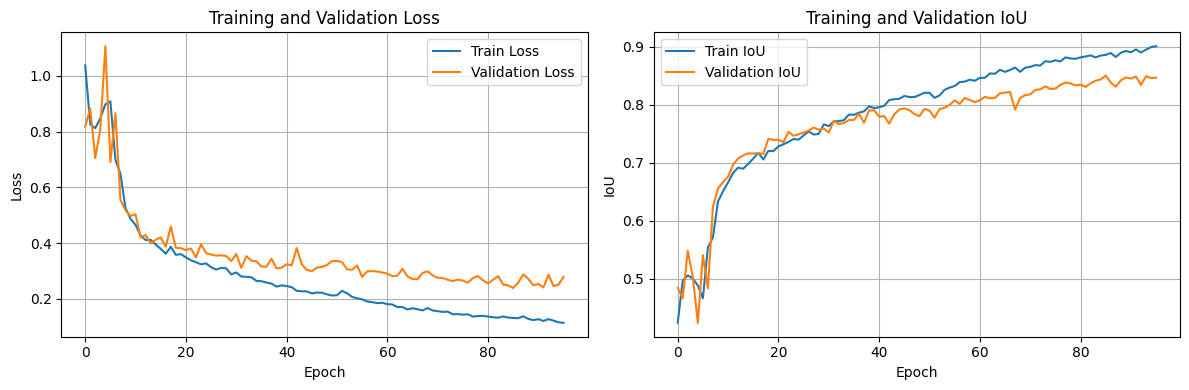

In [13]:
# Hàm vẽ biểu đồ
def plot_training_history(train_losses, val_losses, train_ious, val_ious):
    plt.figure(figsize=(12, 4))
    
    # Biểu đồ Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Biểu đồ IoU
    plt.subplot(1, 2, 2)
    plt.plot(train_ious, label='Train IoU')
    plt.plot(val_ious, label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Gọi hàm vẽ biểu đồ
plot_training_history(train_losses, val_losses, train_ious, val_ious)

Image 1, Box: x_min=70.14, y_min=49.29, width=117.98, height=105.40
Image 1, Box: x_min=27.61, y_min=28.44, width=88.51, height=93.34
Image 2, Box: x_min=50.44, y_min=2.00, width=161.92, height=92.93
Image 2, Box: x_min=0.00, y_min=88.95, width=213.72, height=133.79
Image 3, Box: x_min=83.89, y_min=12.09, width=96.48, height=124.19
Image 3, Box: x_min=43.40, y_min=125.83, width=113.36, height=96.90
Image 4, Box: x_min=1.03, y_min=51.59, width=100.63, height=123.09
Image 4, Box: x_min=131.24, y_min=70.56, width=92.76, height=129.74
Image 5, Box: x_min=3.83, y_min=8.60, width=109.79, height=139.70
Image 5, Box: x_min=113.97, y_min=10.59, width=108.60, height=151.58


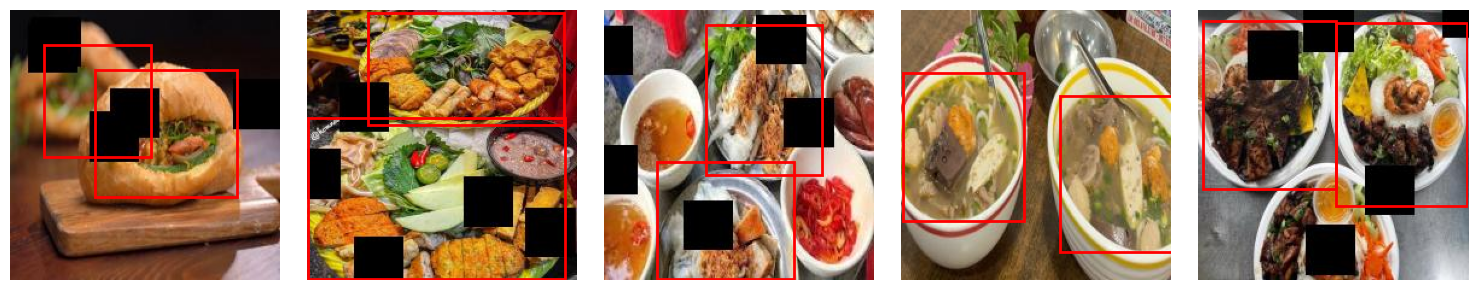

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import ToPILImage
import torch
from PIL import Image

def predict_and_draw_batch(model, test_loader, device, transform, num_images=5):
    model.eval()
    with torch.no_grad():
        # Lấy một batch từ test_loader
        images, _ = next(iter(test_loader))  # Bỏ qua targets vì ta chỉ cần ảnh để dự đoán
        images = images[:num_images].to(device)  # Lấy num_images ảnh đầu tiên
        
        # Dự đoán bounding boxes
        outputs = model(images)  # [num_images, 8]
        outputs = outputs.view(-1, 2, 4).cpu()  # [num_images, 2, 4]
        
        # Chuyển tensor ảnh về định dạng PIL để vẽ
        to_pil = ToPILImage()
        
        # Tạo figure với 5 subplot
        fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
        if num_images == 1:
            axes = [axes]  # Đảm bảo axes là list ngay cả khi chỉ có 1 ảnh
        
        for i in range(num_images):
            image = to_pil(images[i].cpu())  # Chuyển tensor về PIL Image
            ax = axes[i]
            ax.imshow(image)
            ax.axis('off')  # Tắt trục tọa độ
            
            # Vẽ từng bounding box cho ảnh i
            for box in outputs[i]:  # outputs[i] có shape [2, 4]
                x_center, y_center, width, height = box
                x_min = (x_center - width / 2) * 224
                y_min = (y_center - height / 2) * 224
                width = width * 224
                height = height * 224
                
                # Đảm bảo giá trị hợp lệ
                x_min = max(0, x_min)
                y_min = max(0, y_min)
                width = min(width, 224 - x_min)
                height = min(height, 224 - y_min)
                
                print(f"Image {i+1}, Box: x_min={x_min:.2f}, y_min={y_min:.2f}, width={width:.2f}, height={height:.2f}")
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        
        plt.tight_layout()
        plt.show()

# Giả sử bạn đã có test_loader, model, device và transform
# Ví dụ sử dụng
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Gọi hàm để vẽ 5 ảnh từ test_loader
predict_and_draw_batch(model, test_loader, device, transform, num_images=5)